In [13]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import regularizers
from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import numpy as np

In [14]:
input_tensor = Input(shape=(64, 64, 3), dtype='float32', name='input')

#vgg16 모델 불러오기
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [15]:
#vgg16 밑에 레이어 추가
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(2048, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(1024, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [16]:
additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)             

In [17]:
X_train, X_test, y_train, y_test = np.load('trial.npy', allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(645, 64, 64, 3)
645


In [18]:
#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [ ]:
# Our vectorized labels
#y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
#y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [19]:
history = additional_model.fit(X_train, y_train, batch_size = 16,
                               epochs = 10,
                               validation_data = (X_test, y_test))

Epoch 1/10
41/41 [==============================] - 3s 78ms/step - loss: 281.0401 - acc: 0.6264 - val_loss: 252.0921 - val_acc: 0.9306
Epoch 2/10
41/41 [==============================] - 2s 53ms/step - loss: 228.3839 - acc: 0.8434 - val_loss: 202.9284 - val_acc: 0.9630
Epoch 3/10
41/41 [==============================] - 2s 53ms/step - loss: 180.4701 - acc: 0.9504 - val_loss: 156.5108 - val_acc: 1.0000
Epoch 4/10
41/41 [==============================] - 2s 53ms/step - loss: 136.5431 - acc: 0.9659 - val_loss: 115.3412 - val_acc: 1.0000
Epoch 5/10
41/41 [==============================] - 2s 53ms/step - loss: 97.8404 - acc: 0.9860 - val_loss: 80.0648 - val_acc: 1.0000
Epoch 6/10
41/41 [==============================] - 2s 53ms/step - loss: 66.5141 - acc: 0.9814 - val_loss: 53.1383 - val_acc: 1.0000
Epoch 7/10
41/41 [==============================] - 2s 53ms/step - loss: 43.6425 - acc: 0.9876 - val_loss: 34.7495 - val_acc: 0.9954
Epoch 8/10
41/41 [==============================] - 2s 53ms/s

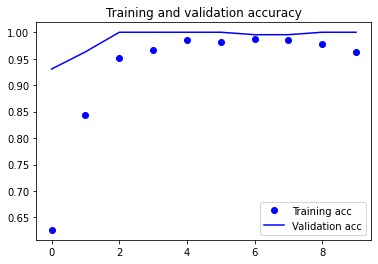

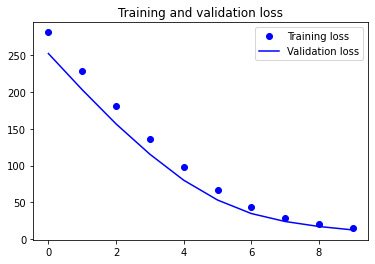

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
model_json = additional_model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

additional_model.save_weights("model_w.h5")
print("Saved model to disk")

Saved model to disk
